In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys
pkg_path = "/nfs/students/winter-term-2020/project-1/project-1/audio_classification"
if pkg_path not in sys.path:
    sys.path.append(pkg_path)

pkg_path = "/nfs/students/winter-term-2020/project-1/project-1/foolbox"
if pkg_path not in sys.path:
    sys.path.append(pkg_path)

import os
import yaml
import torch
from audio_classification.tools import attack_model, attack_model_for_randomize_smoothing, attack_model_for_adv

torch.cuda.empty_cache()
#device = torch.device('cpu')
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
project_dir = '/nfs/students/winter-term-2020/project-1/'
save_folder = '/nfs/students/winter-term-2020/project-1/project-1/attack_results/adv'

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 10, 'CRNN': {'RANDOMISED_SMOOTHING': False, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False, 'SMOOTH_ADV': True}}, 'DATASET': {'NAME': 'UrbanSounds8K', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'VAL_FOLD': 9, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'WEIGHT': 'None'}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK_VAL': {'EPS': 256, 'NUM_STEPS': 2, 'MTRAIN': 2, 'NO_GRAD': True, 'MULTI_NOISE': True}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/final-adv', 'NUM_GPUS': 1, 'MAX_EPOCH': 125, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.01, 'STEP_SIZE': 25, 'SIGMA': 0.25, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights/final-adv', 'SAVE_TOP_K': 1}, 'ATTACK': Tr

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 3264.41 seconds
[0.74125, 0.6125, 0.485, 0.38125, 0.30874999999999997, 0.24250000000000005, 0.19625000000000004, 0.16000000000000003, 0.13875000000000004, 0.10124999999999995, 0.08750000000000002, 0.07874999999999999, 0.06625000000000003, 0.06625000000000003, 0.06125000000000003, 0.05625000000000002, 0.05500000000000005, 0.05249999999999999, 0.05125000000000002, 0.04874999999999996]


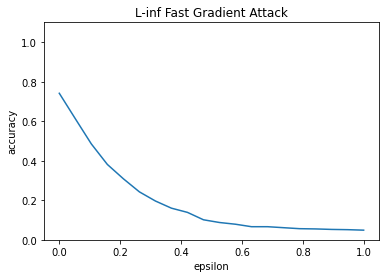

In [3]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 1
title = 'us8k_adv_0.25'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k-0.25.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/final-adv/crnn-us8k-adv-sigma-0.25-eps-256-epoch=31-val_acc=0.738.ckpt'
attack_model_for_adv(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 10, 'CRNN': {'RANDOMISED_SMOOTHING': False, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False, 'SMOOTH_ADV': True}}, 'DATASET': {'NAME': 'UrbanSounds8K', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'VAL_FOLD': 9, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'WEIGHT': 'None'}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK_VAL': {'EPS': 256, 'NUM_STEPS': 2, 'MTRAIN': 2, 'NO_GRAD': True, 'MULTI_NOISE': True}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/final-adv', 'NUM_GPUS': 1, 'MAX_EPOCH': 125, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.01, 'STEP_SIZE': 25, 'SIGMA': 0.5, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights/final-adv', 'SAVE_TOP_K': 1}, 'ATTACK': Tru

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 3266.18 seconds
[0.72375, 0.60875, 0.48250000000000004, 0.35875, 0.27625, 0.22124999999999995, 0.16000000000000003, 0.13124999999999998, 0.10875000000000001, 0.09125000000000005, 0.0675, 0.057499999999999996, 0.053749999999999964, 0.05500000000000005, 0.04874999999999996, 0.03874999999999995, 0.036250000000000004, 0.026249999999999996, 0.030000000000000027, 0.02749999999999997]


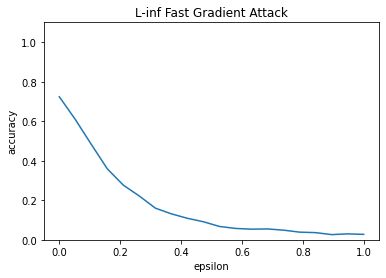

In [4]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 1
title = 'us8k_adv_0.5'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k-0.5.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/final-adv/crnn-us8k-adv-sigma-0.5-eps-256-epoch=46-val_acc=0.728.ckpt'
attack_model_for_adv(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'MODEL': {'NAME': 'LitCRNN', 'NUM_CLASSES': 10, 'CRNN': {'RANDOMISED_SMOOTHING': False, 'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': False, 'SMOOTH_ADV': True}}, 'DATASET': {'NAME': 'UrbanSounds8K', 'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'FILE_PATH': '/nfs/students/winter-term-2020/project-1/datasets/UrbanSound8K/audio/', 'VAL_FOLD': 9, 'AUGMENTATION': 'none', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'WEIGHT': 'None'}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK_VAL': {'EPS': 256, 'NUM_STEPS': 2, 'MTRAIN': 2, 'NO_GRAD': True, 'MULTI_NOISE': True}, 'LOSS': 'cross_entropy', 'SOLVER': {'LOG_PATH': '../logs/final-adv', 'NUM_GPUS': 1, 'MAX_EPOCH': 125, 'MIN_EPOCH': 1, 'LEARNING_RATE': 0.001, 'WEIGHT_DECAY': 0.01, 'STEP_SIZE': 25, 'SIGMA': 1, 'GAMMA': 0.5}, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k', 'SAVE_PATH': '../weights/final-adv', 'SAVE_TOP_K': 1}, 'ATTACK': True}

/nfs/homedirs/vashisht/anaconda3/envs/project_1/lib/python3.7/site-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 3270.11 seconds
[0.7475, 0.61625, 0.5625, 0.48750000000000004, 0.40874999999999995, 0.33875, 0.275, 0.21499999999999997, 0.16749999999999998, 0.13875000000000004, 0.125, 0.10124999999999995, 0.08750000000000002, 0.08250000000000002, 0.06625000000000003, 0.06499999999999995, 0.05500000000000005, 0.05874999999999997, 0.04749999999999999, 0.03874999999999995]


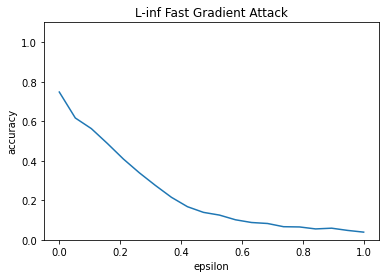

In [5]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 1
title = 'us8k_adv_1'
config_path = '/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_urbansound8k-1.yaml'
pretrained_path = '/nfs/students/winter-term-2020/project-1/project-1/weights/final-adv/crnn-us8k-adv-sigma-1-eps-256-epoch=116-val_acc=0.747.ckpt'
attack_model_for_adv(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)